In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.Ml_methods import Ml_methods
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wandb
from scipy import stats
from scipy.stats import linregress
import copy
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Constants

In [3]:
chosen_rois_dict = constants.ROI_ALL_BRAIN
params_to_work_with = constants.ALL_PARAMS

Load the data and proccess it

In [4]:
def load_data(data_path, slopes=None, outliers=[]):
    subjects_raw_data = DataProcessor(
        data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(
        subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(
        analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(
        chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects


def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for param in params:
        data_copy[param] = stats.zscore(data_copy[param], nan_policy='omit')

    return data

In [5]:
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB']
# outliers = []
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(
    constants.PATH_TO_ALL_BRAIN_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(
    constants.PATH_TO_ALL_BRAIN_all_params_z_score, outliers=outliers)

print(
    f'num young: {young_subjects_raw.subjects.nunique()}, num old: {old_subjects_raw.subjects.nunique()}')

num young: 16, num old: 14


In [6]:
DataProcessor.outliers_counter(
    chosen_data_raw, params_to_work_with, chosen_rois_dict)

outliers counter: {'H023_IN': 36, 'H039_JH': 27, 'H050_AB': 20, 'H041_VG': 11, 'H019_AF': 10, 'H037_YB': 9, 'H025_SH': 7, 'H032_JD': 7, 'H033_MB': 7, 'H052_OF': 7, 'H034_HB': 6, 'H031_IN': 6, 'H026_LY': 5, 'H022_YR': 5, 'H044_AZ': 4, 'H051_YK': 4, 'H028_LC': 3, 'H030_NS': 3, 'H035_DN': 3, 'H061_SE': 2, 'H021_DH': 2, 'H018_AS': 2, 'H020_RR': 2, 'H038_GB': 2, 'H043_OS': 1, 'H055_MY': 1, 'H045_PO': 1, 'H048_GA': 1, 'H040_RK': 1}


## Raw data analysis 

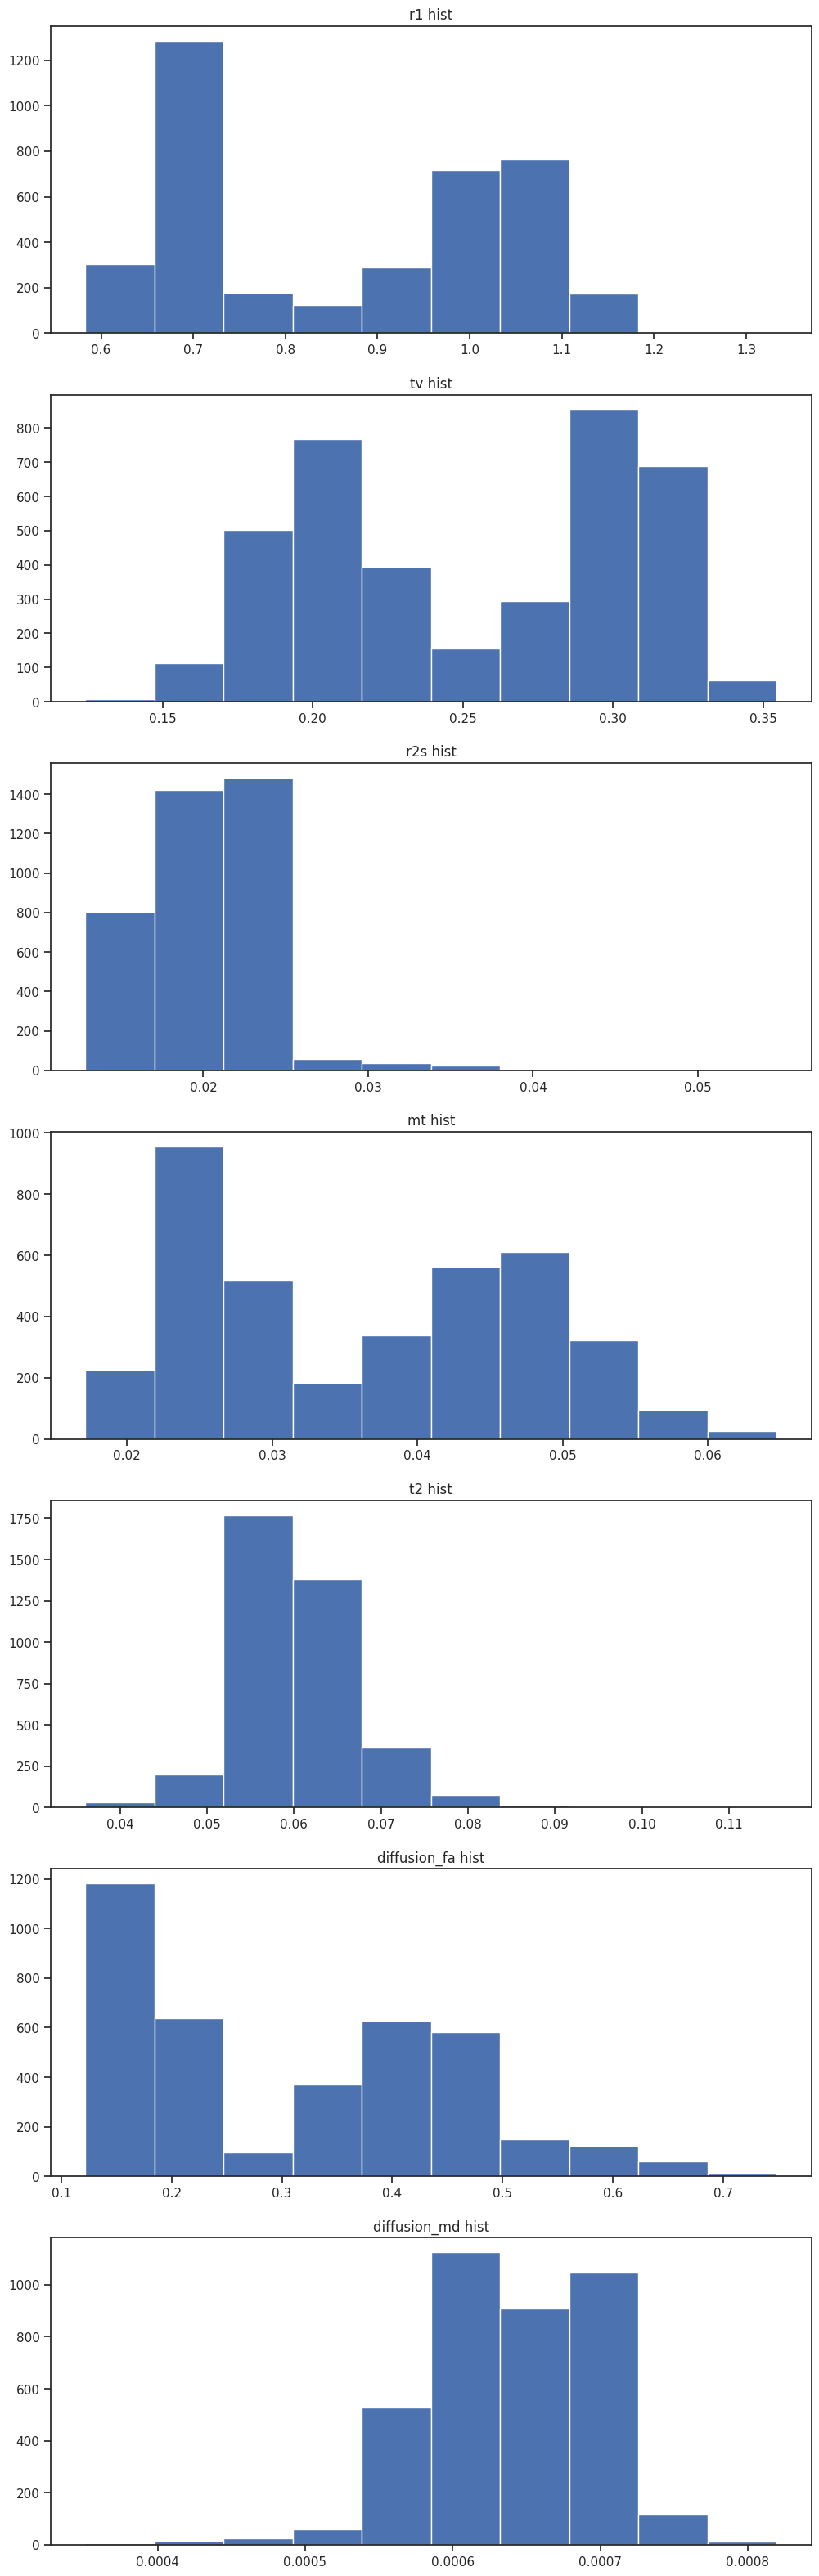

In [6]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(12, 40))

for i, param in enumerate(params_to_work_with):
    ax[i].set_title(f'{param} hist')
    ax[i].hist(chosen_data_raw[param])

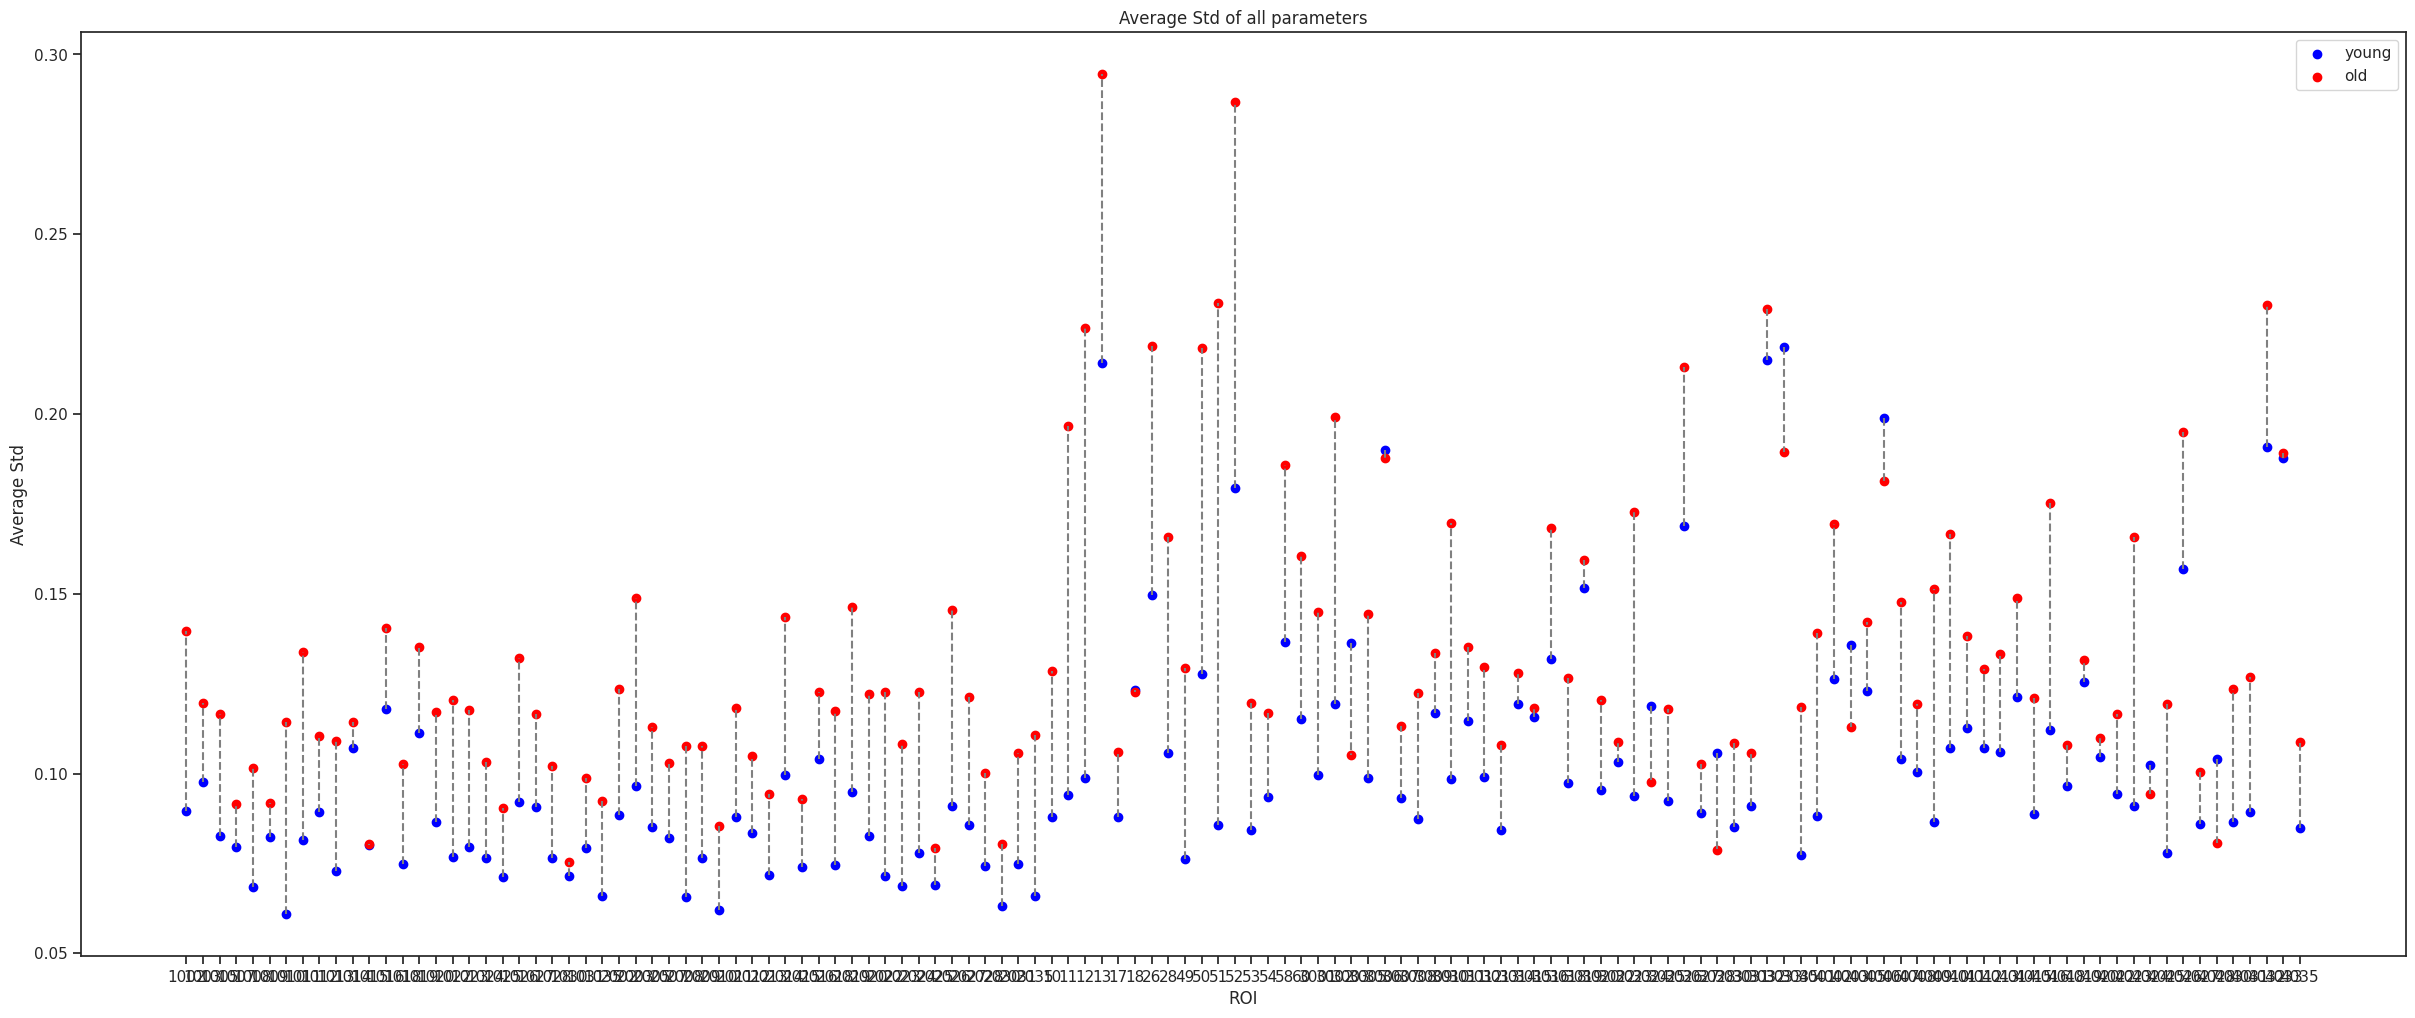

In [7]:
%autoreload 2
data_groups = [(young_subjects_z_score, 'blue', 'young'), (old_subjects_z_score, 'red', 'old')]
StatisticsWrapper.calculate_mean_std_for_rois(data_groups, chosen_rois_dict.keys(), params_to_work_with, fig_size=(30, 12))

F test to check if the age is significant to the cv

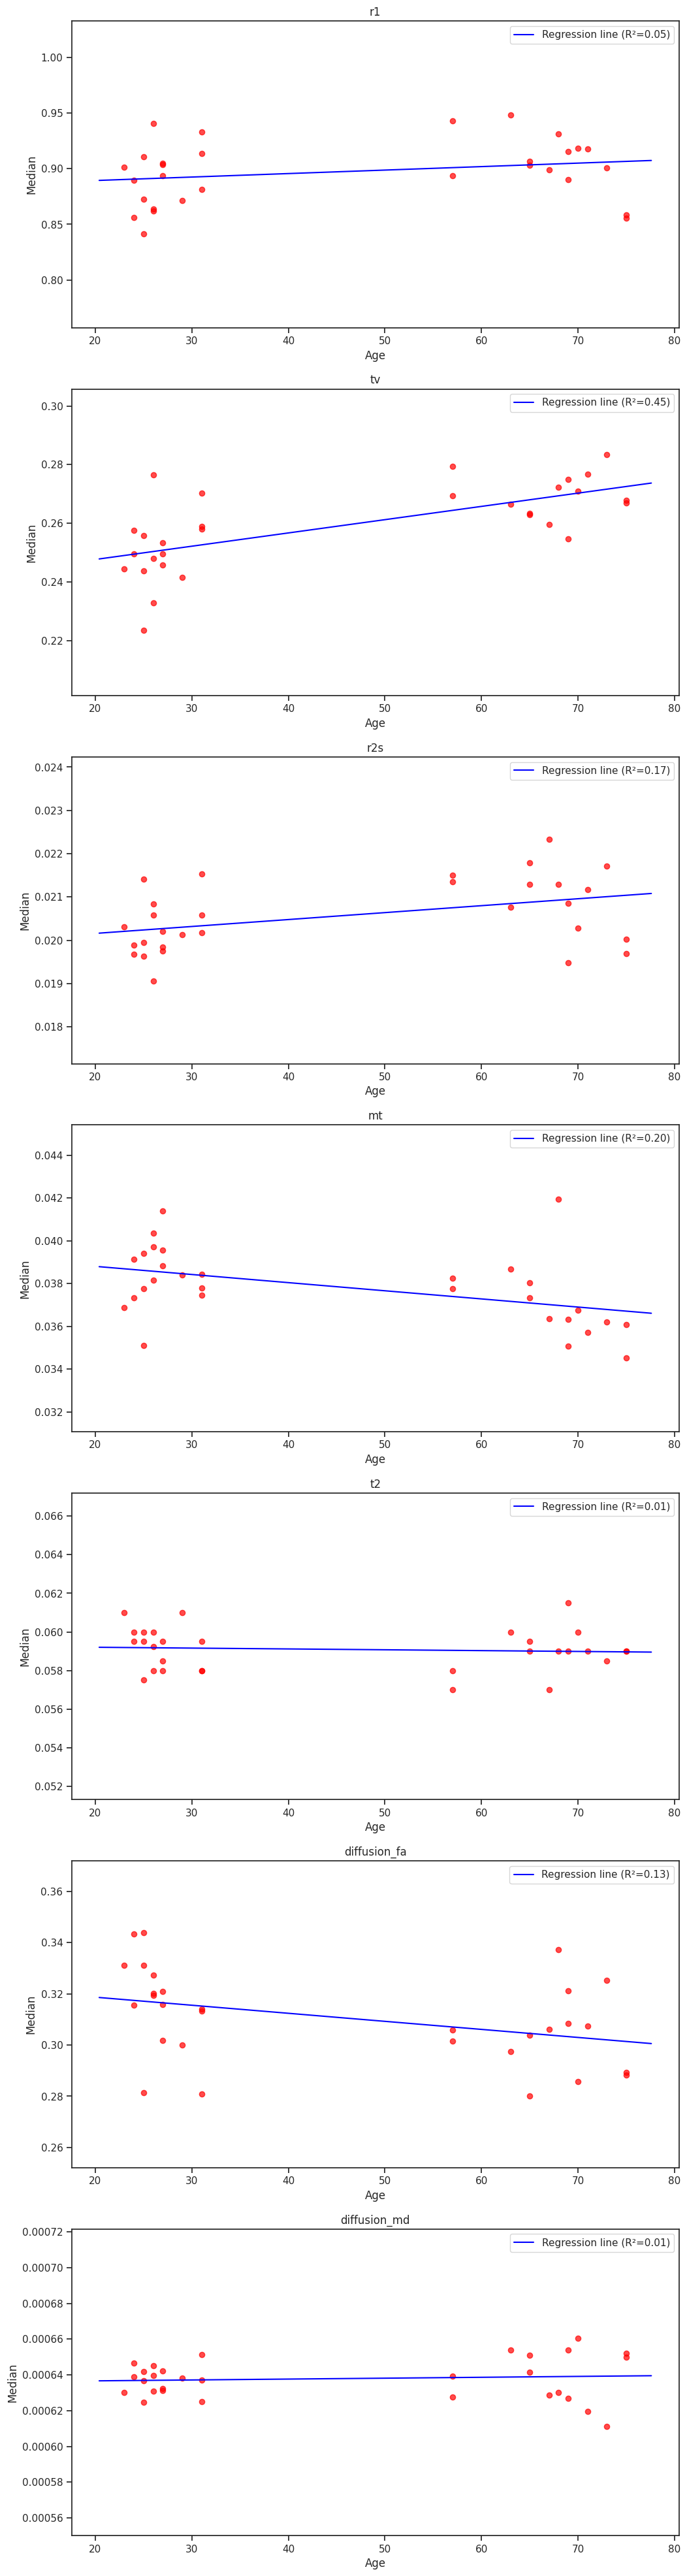

In [8]:
fig, ax = plt.subplots(nrows=len(params_to_work_with),
                       ncols=1, figsize=(12, 50))

for i, param in enumerate(params_to_work_with):
    medians = chosen_data_raw.groupby('subjects')[[param, 'Age']].median()
    ax[i].scatter(medians['Age'], medians[param], color='red', s=35, alpha=0.7)
    ax[i].set_title(f'{param}')
    ax[i].set_xlabel('Age')
    ax[i].set_ylabel('Median')
    lim = 0.1
    ax[i].set_ylim([min(medians[param]) - lim*min(medians[param]),
                   max(medians[param]) + lim*min(medians[param])])

    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = linregress(
        medians['Age'], medians[param])
    x_values = np.array(ax[i].get_xlim())
    y_values = intercept + slope * x_values
    ax[i].plot(x_values, y_values, color='blue',
               label=f'Regression line (R²={r_value**2:.2f})')
    ax[i].legend()

Mean

In [23]:
%autoreload 2
rois = [('ctx-rh-rostralmiddlefrontal', 'ctx-rh-insula'), ('ctx-rh-rostralmiddlefrontal', 'ctx-rh-inferiortemporal'),
         ('ctx-rh-insula', 'ctx-rh-inferiortemporal'), ('ctx-rh-caudalmiddlefrontal', 'ctx-lh-isthmuscingulate'),
           ('ctx-rh-parstriangularis', 'ctx-rh-caudalanteriorcingulate'), ('ctx-lh-middletemporal', 'ctx-rh-superiorfrontal'), 
           ('ctx-lh-lateraloccipital', 'ctx-lh-parsorbitalis')]

data_groups = [young_subjects_z_score, old_subjects_z_score]
colors = ['red', 'blue']

for roi_pair in rois:
    StatisticsWrapper.show_rois_differences_in_polar(data_groups, [roi_pair[0], roi_pair[1]], 
                                                     params_to_work_with, ('young mean', 'old mean'), colors, method='median')

std

## Check correlations on the normalized data

In [9]:
def show_correlations_stats(all_data, young_data, old_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                              title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                      group_title='Correlations of young group', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois,
                                                    group_title='Correlations of old group', method=method)

    PlotsManager.plot_heatmap(
        old_result - young_result, 'differences of old and young', project_name=None)
    young_corr_means, old_corr_means = show_corr_mean(
        young_result, old_result, clusters_rois, 'Average correlations')


def show_corr_mean(young_result, old_result, clusters_rois, title):
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1)
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1)

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'{title}')
    ax.scatter(clusters_rois, young_result['corr_mean'].to_numpy(
    ), color='blue', s=20, alpha=0.7, label='young')
    ax.scatter(clusters_rois, old_result['corr_mean'].to_numpy(
    ), color='red', s=20, alpha=0.7, label='old')

    ax.set_xticks(clusters_rois)
    ax.set_xticklabels(clusters_rois, rotation='vertical', fontsize=8)

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, young_result['corr_mean'].to_numpy(), old_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')

    # ax.set_facecolor('white')
    ax.grid(True)
    ax.legend()

    return young_result['corr_mean'], old_result['corr_mean']


def show_distances(method, params_to_work_with, all_data, young_subjects, old_subjects, title):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(
        all_data, params_to_work_with, 'single', title="all")['dendrogram_data']['ivl']
    young_distances = StatisticsWrapper.roi_distances(
        young_subjects, params_to_work_with, clusters_rois, method=method, title=f'Young rois {title}')
    old_distances = StatisticsWrapper.roi_distances(
        old_subjects, params_to_work_with, clusters_rois, method=method, title=f'Old rois {title}')

    _, __ = show_corr_mean(young_distances, old_distances,
                           clusters_rois, f'Average ROIS {title}')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


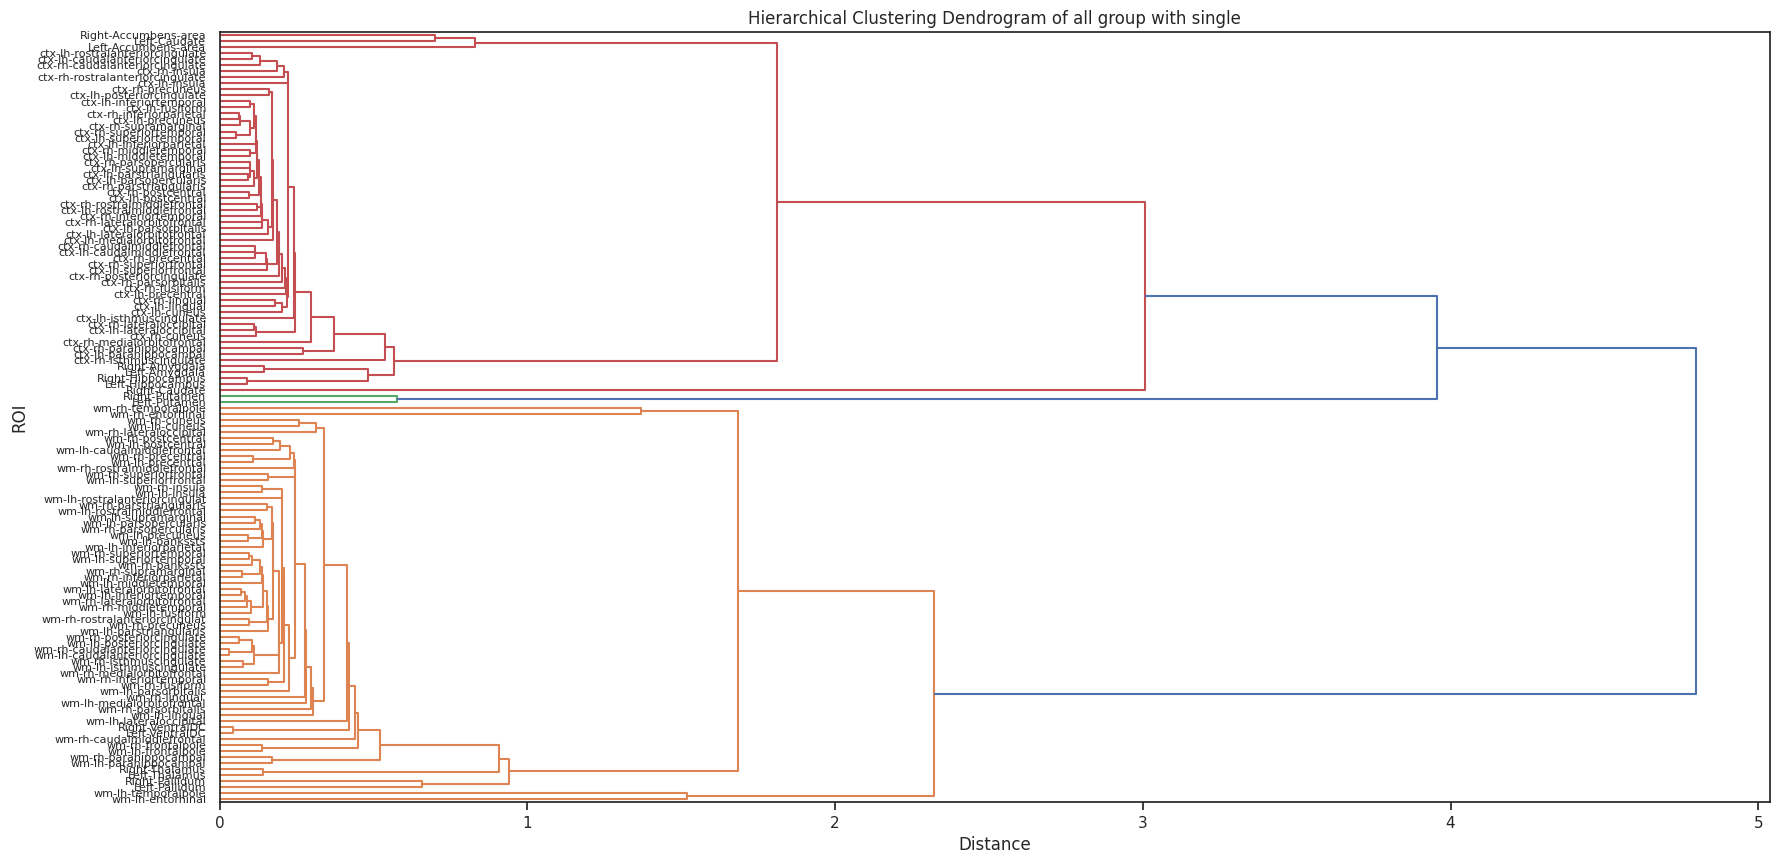

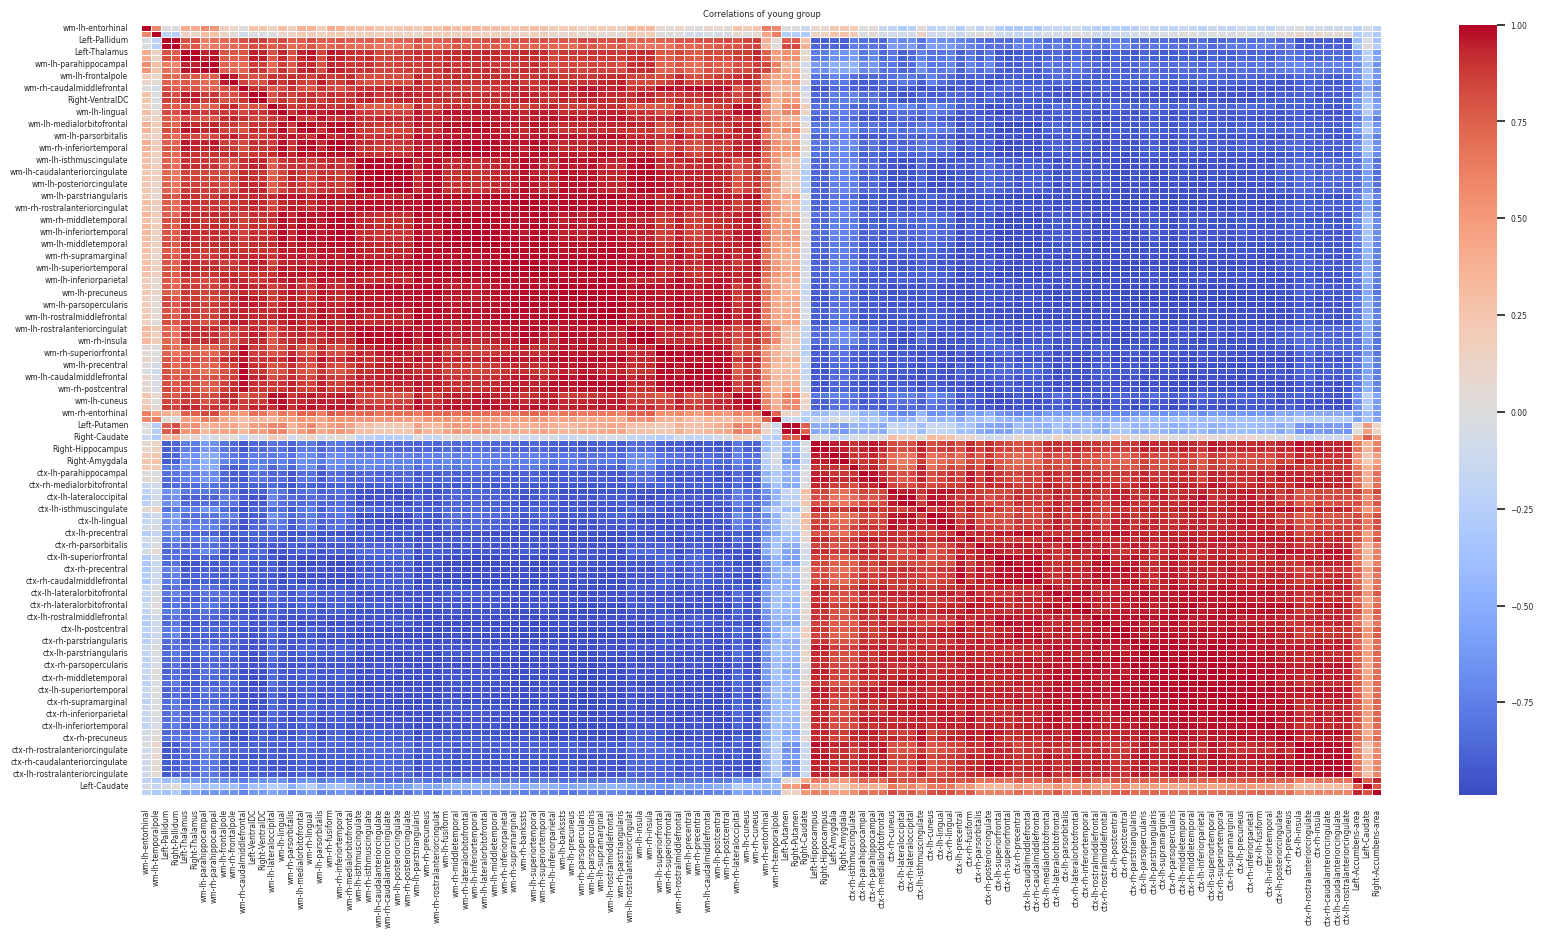

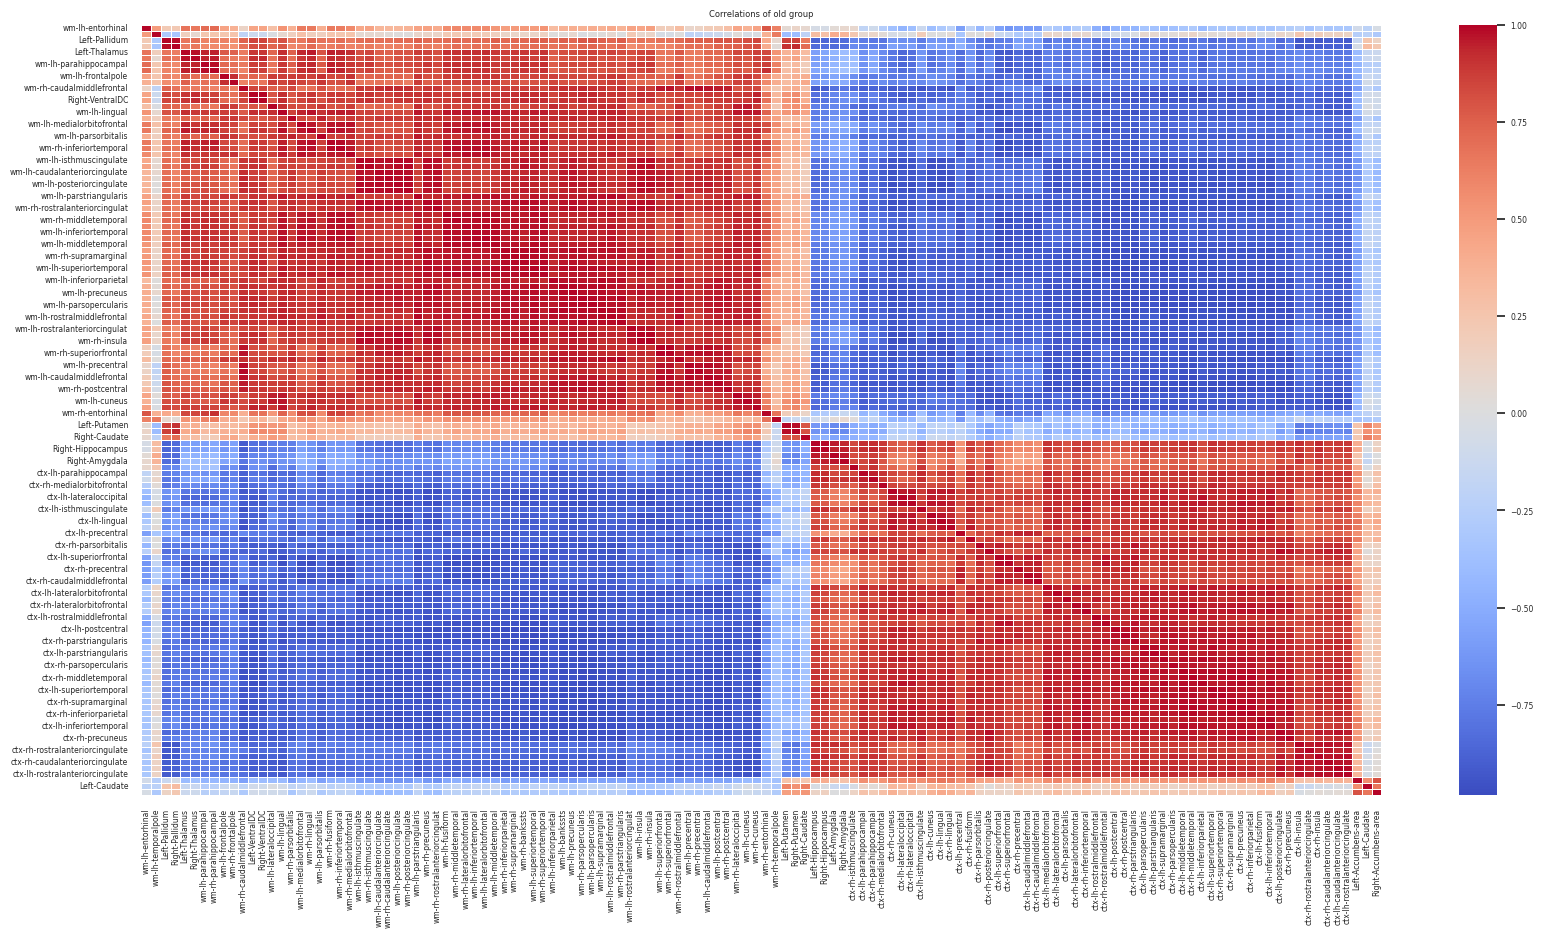

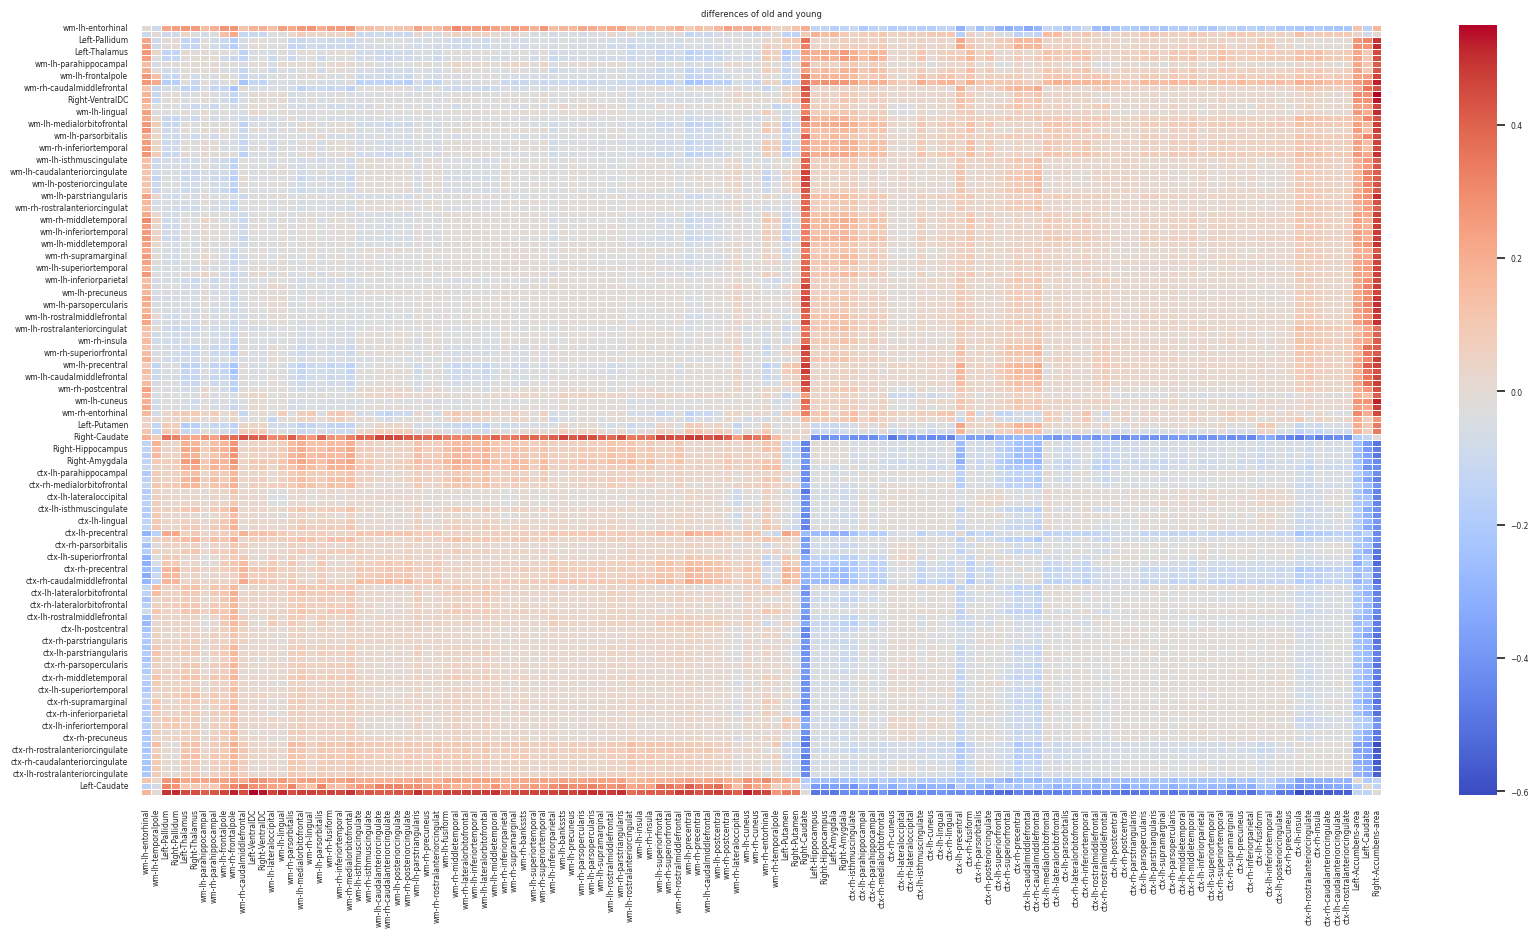

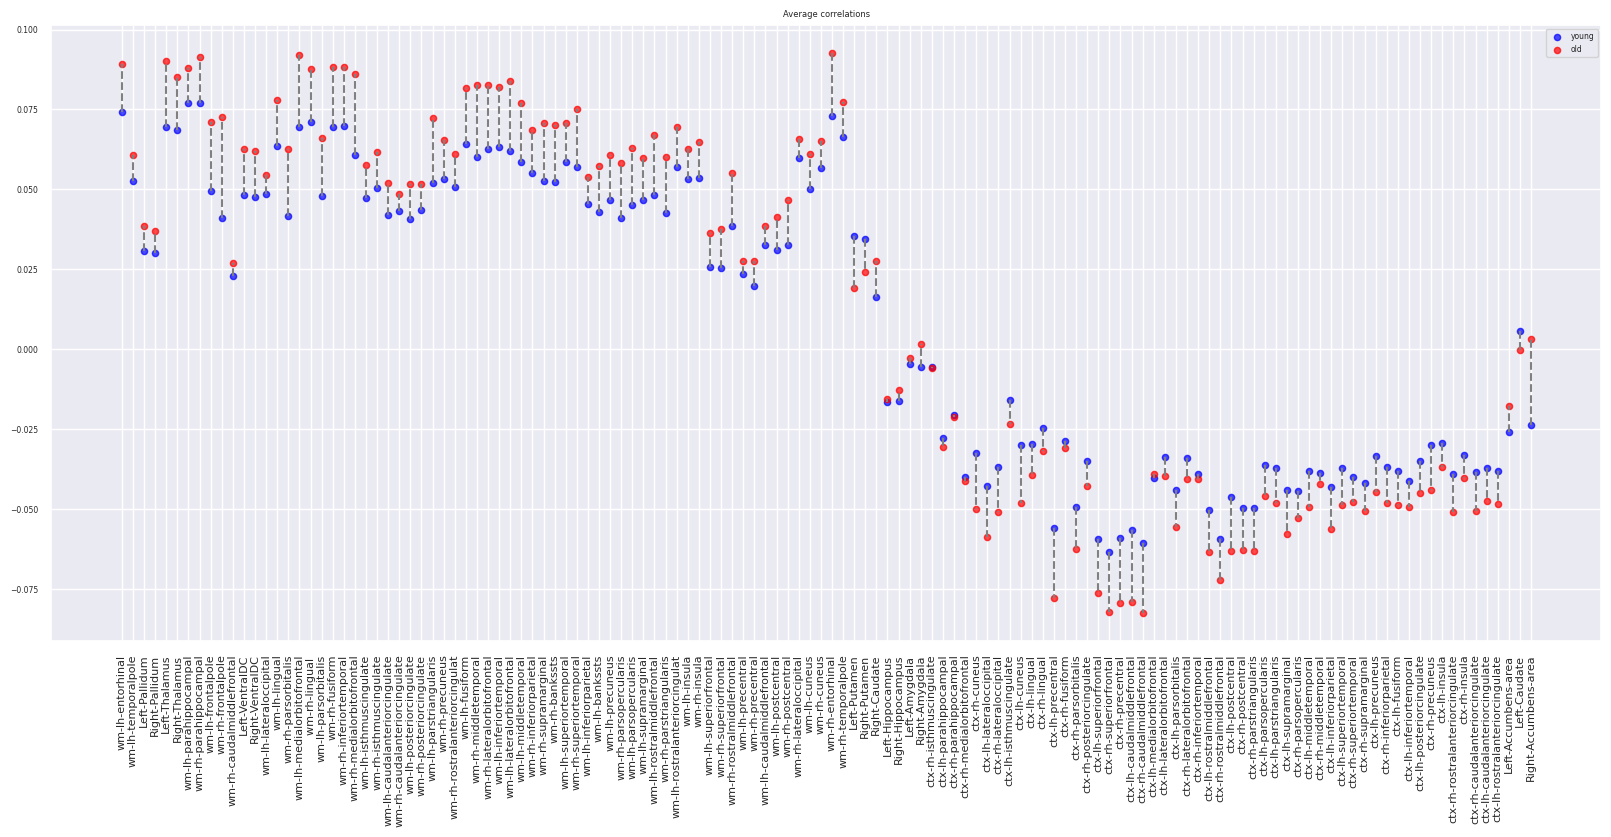

In [10]:
%autoreload 2
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'pearson')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:534: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


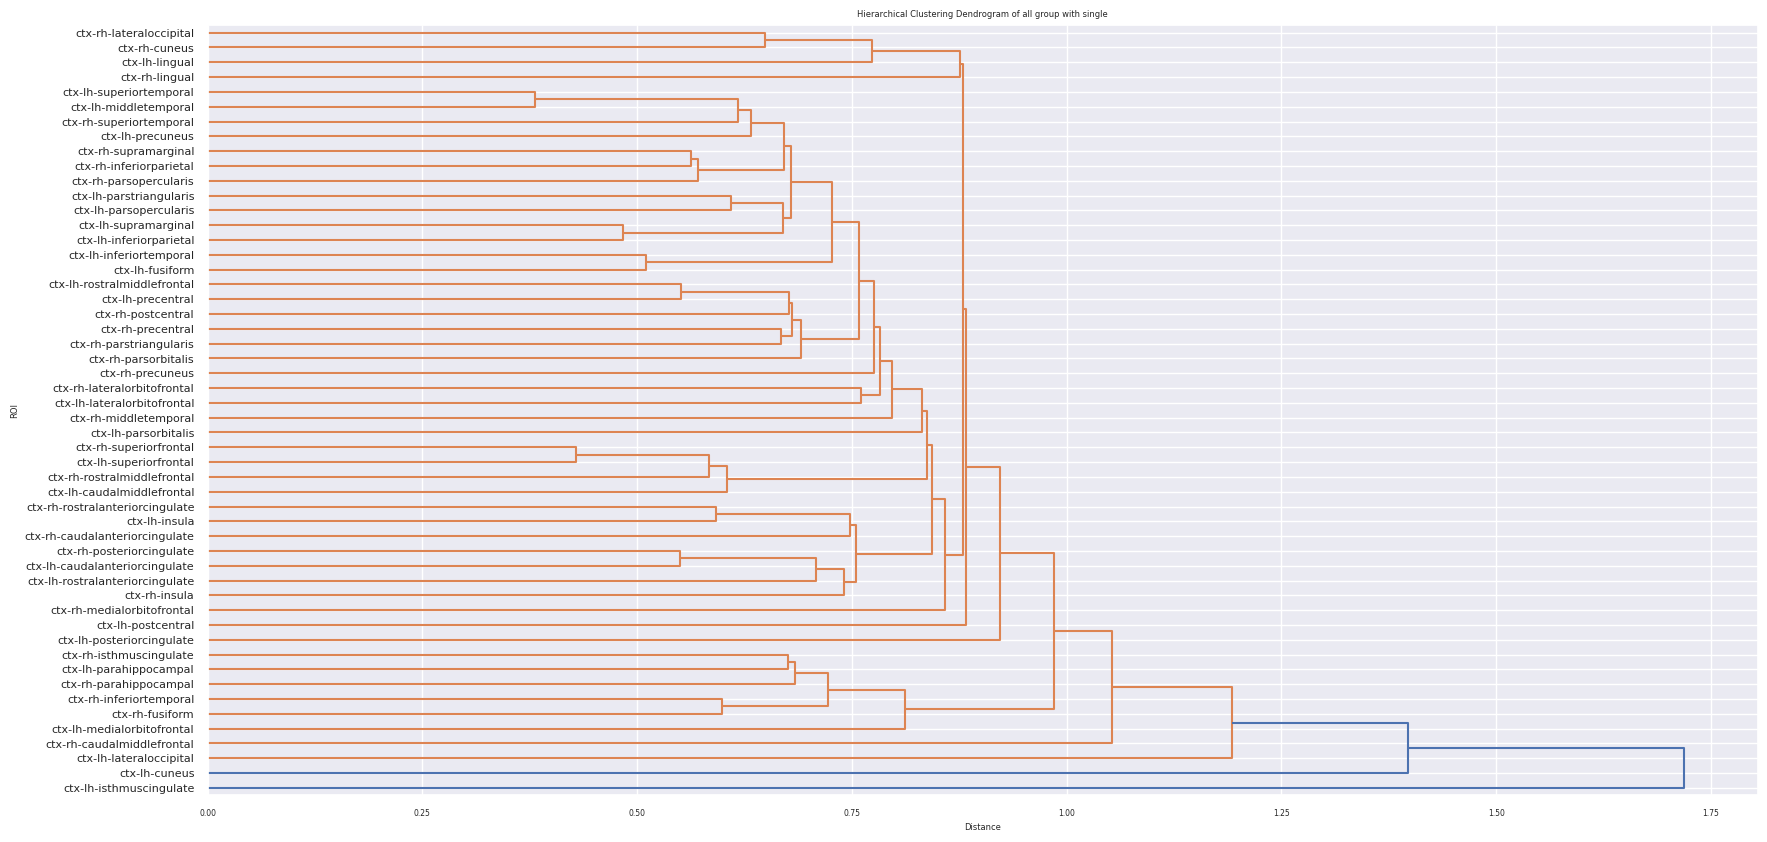

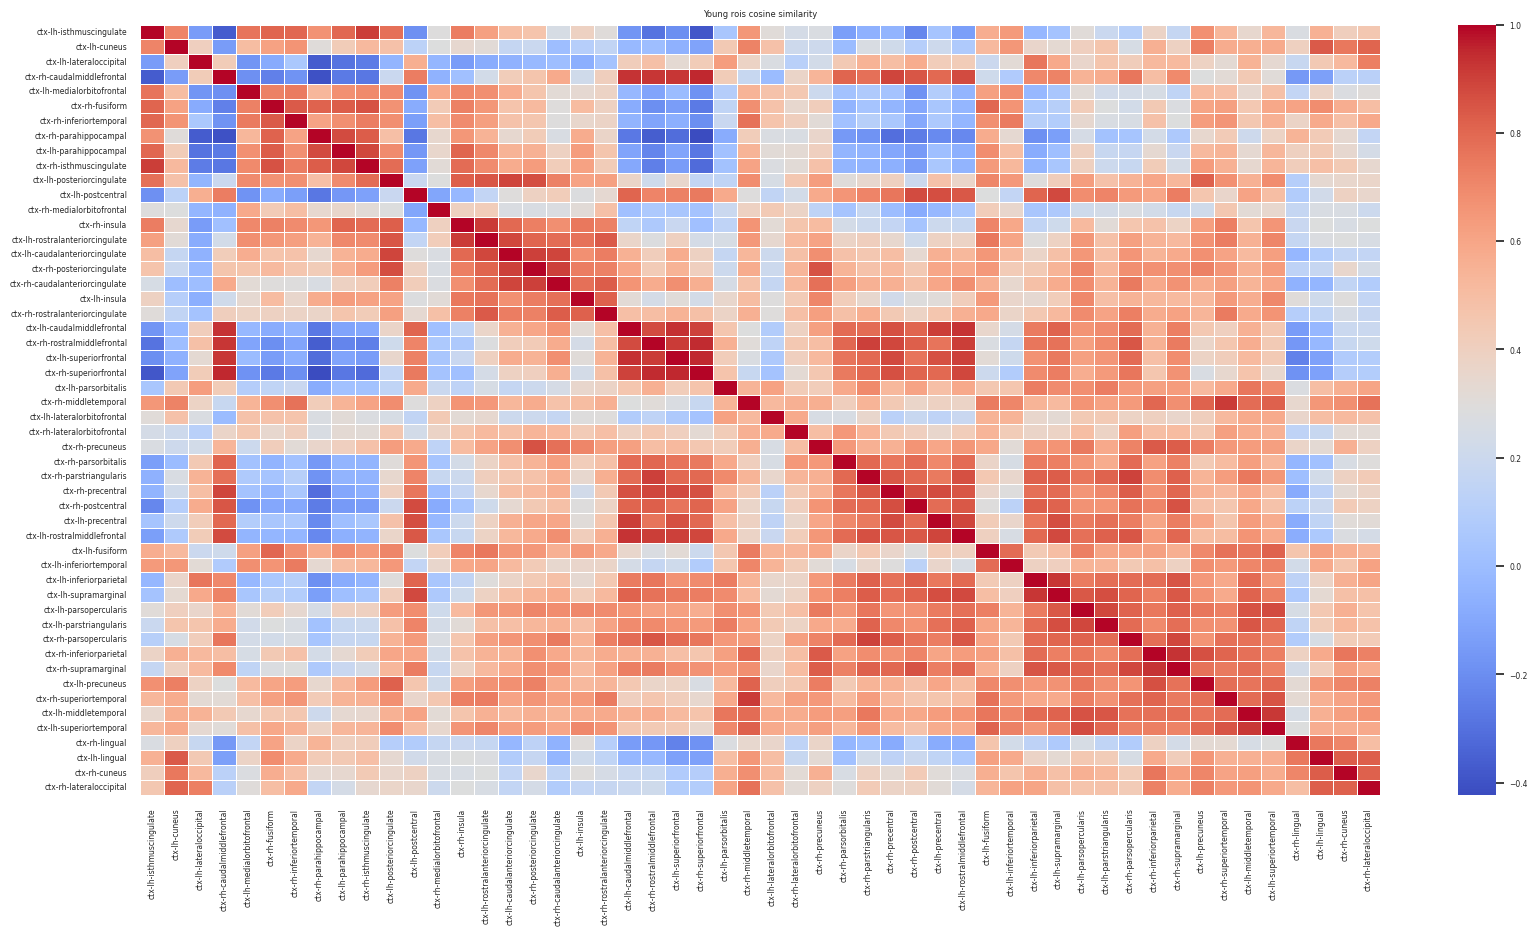

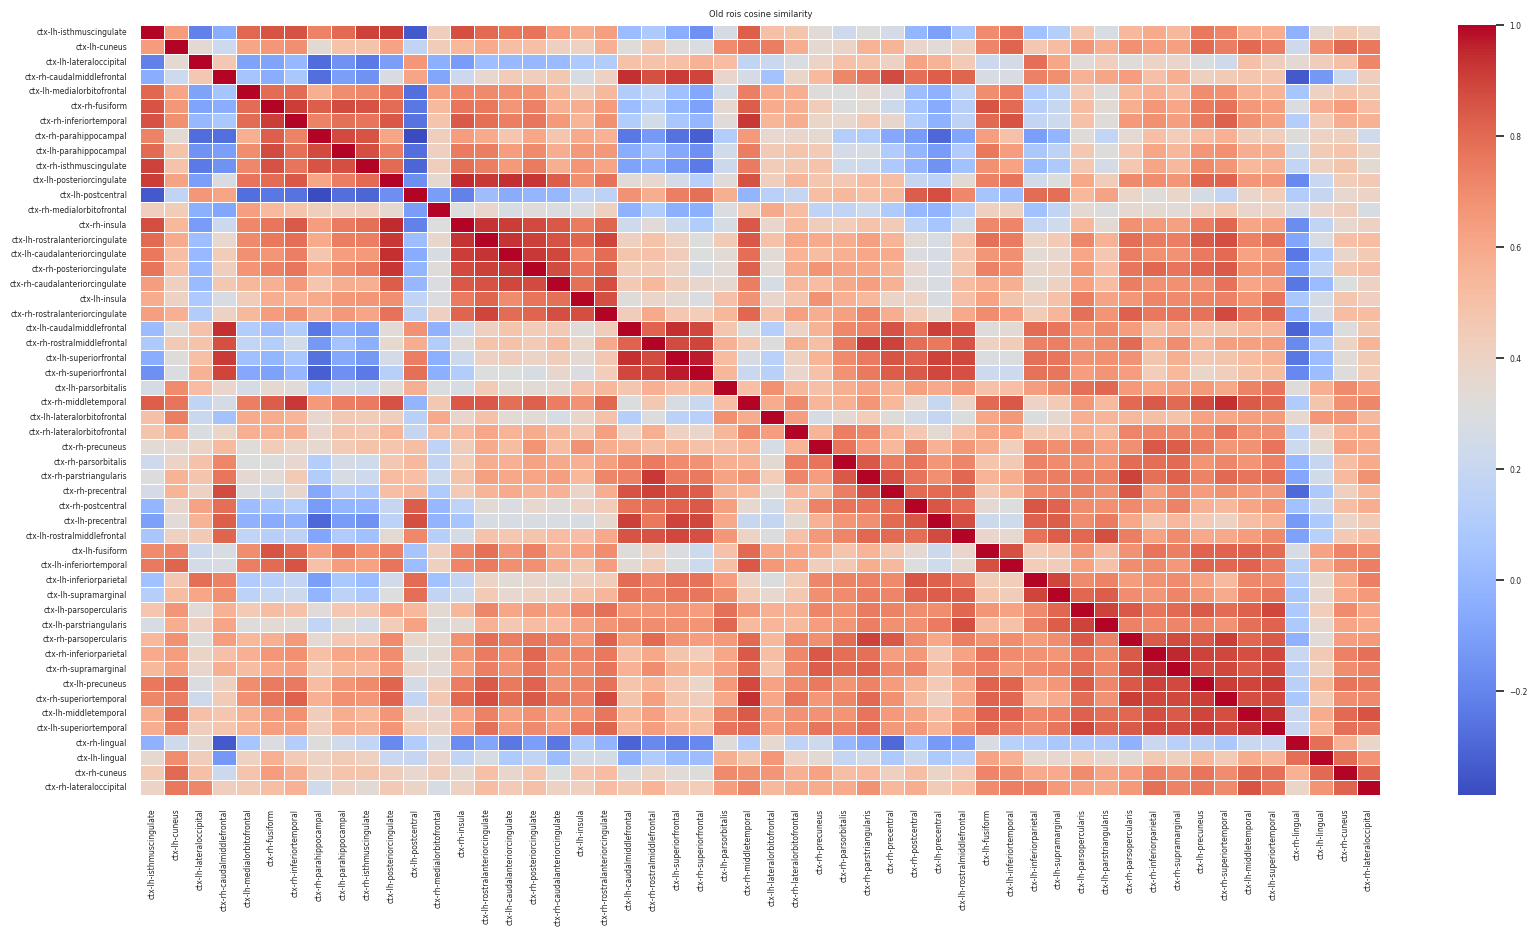

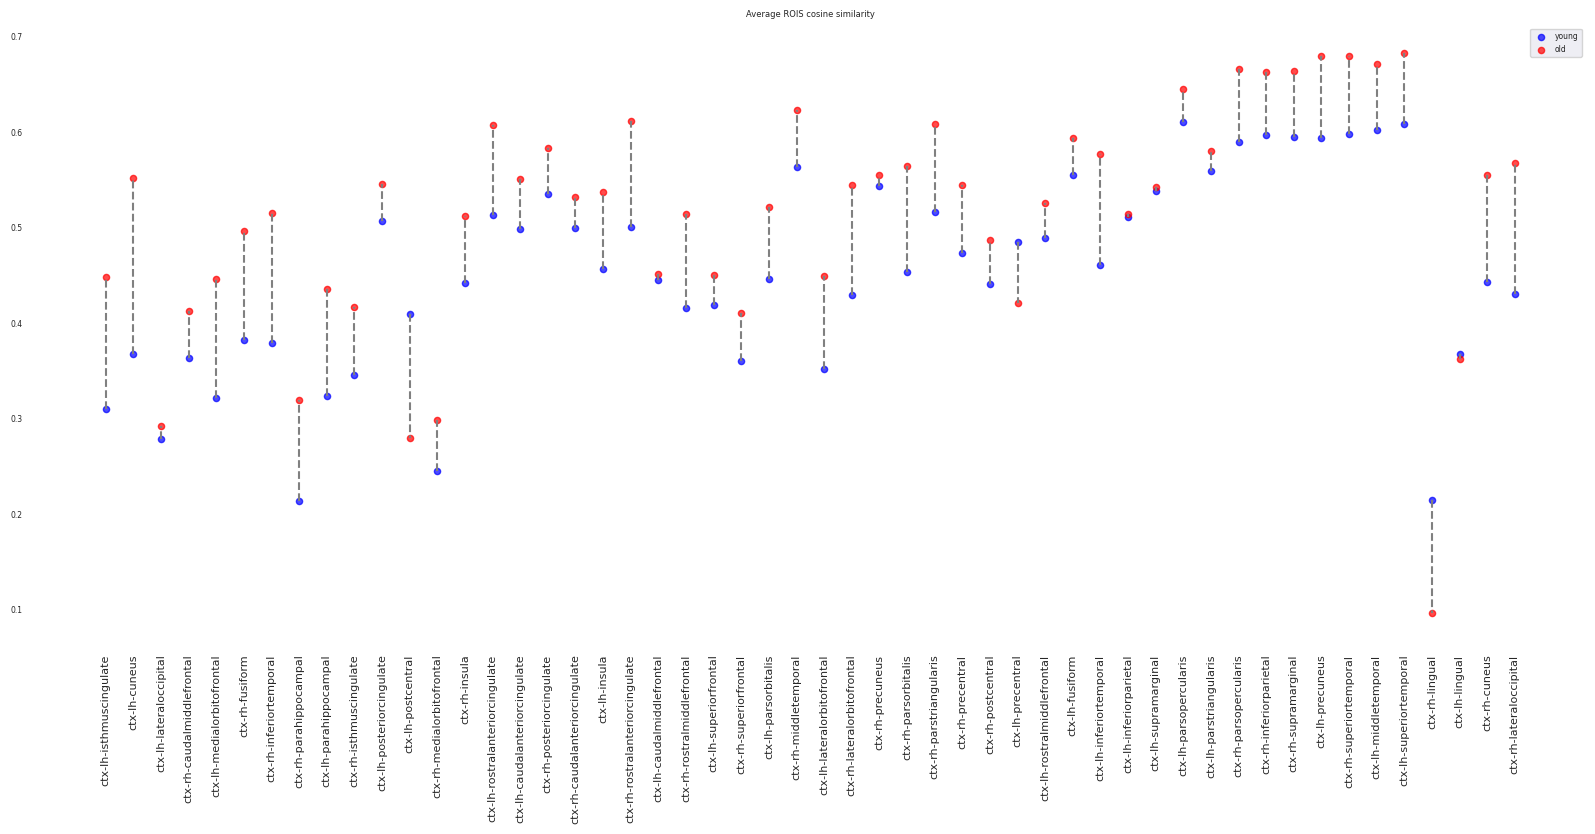

In [10]:
show_distances(cosine_similarity, params_to_work_with, chosen_data_z_score,
               young_subjects_z_score, old_subjects_z_score, 'cosine similarity')

Check t_test on the young and old groups

param r1 number of areas with significance differences: 48
param tv number of areas with significance differences: 42
param r2s number of areas with significance differences: 79
param mt number of areas with significance differences: 39
param t2 number of areas with significance differences: 70
param diffusion_fa number of areas with significance differences: 72
param diffusion_md number of areas with significance differences: 81


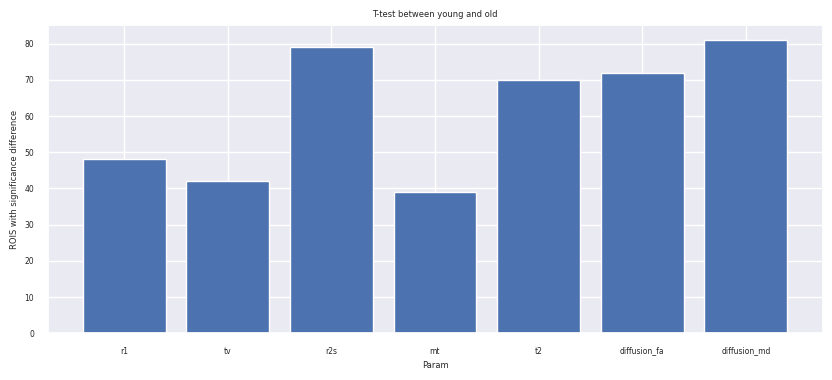

In [11]:
%autoreload 2
StatisticsWrapper.t_test_per_parameter_per_area(young_subjects_z_score, old_subjects_z_score, chosen_rois_dict, 'ROI', params_to_work_with)

Subjects clustering 

In [12]:
def reduce_dim(model, data, drop_label=True):
    if drop_label:
        res = model.fit_transform(data.drop(columns='label'))
    else:
        res = model.fit(data.drop(columns='label'), data['label']).transform(
            data.drop(columns='label'))

    # Generate dynamic column names
    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    reduced_data['label'] = data['label']
    return reduced_data

In [13]:
young_features_df = pd.pivot_table(
    young_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
old_features_df = pd.pivot_table(
    old_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
data_features_df = pd.pivot_table(
    chosen_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

young_mask = young_features_df.index
old_mask = old_features_df.index

# Assign labels directly to data_reduced_tsne DataFrame
data_features_df.loc[young_mask, 'label'] = 'young'
data_features_df.loc[old_mask, 'label'] = 'old'

In [14]:
dim = 0.95
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=3, random_state=36)

data_reduced_pca = reduce_dim(pca, data_features_df, drop_label=True)
# data_reduced_tsne = reduce_dim(tsne, data_features_df, drop_label=True)

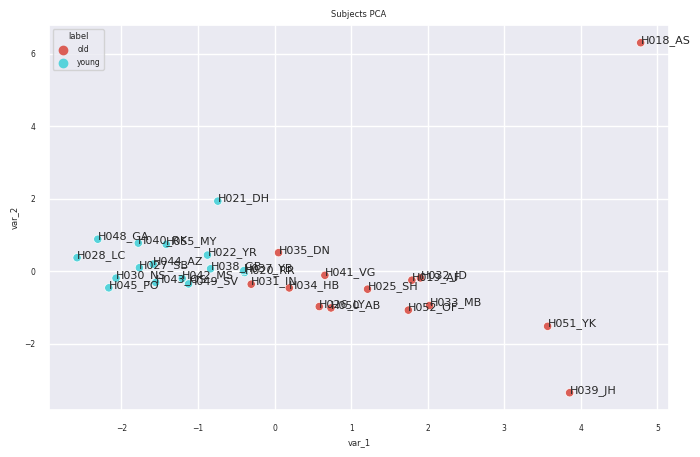

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(
    x="var_1", y="var_2",
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=data_reduced_pca,
    legend="full",
    ax=ax
).set_title('Subjects PCA')

for i, txt in enumerate(data_reduced_pca.index):
    ax.annotate(
        txt, (data_reduced_pca['var_1'][i], data_reduced_pca['var_2'][i]), fontsize=8)

Rois clustering

In [11]:
all_features_df = chosen_data_z_score[params_to_work_with]

young_mask = young_subjects_z_score.index
old_mask = old_subjects_z_score.index

# Assign labels directly to DataFrame
all_features_df.loc[young_mask, 'label'] = 'young'
all_features_df.loc[old_mask, 'label'] = 'old'

/tmp/ipykernel_1179207/490072393.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_features_df.loc[young_mask, 'label'] = 'young'


In [17]:
# model = TSNE(n_components=2, perplexity=50, random_state=0)
model = PCA(n_components=2)
all_df_reduced = reduce_dim(model, all_features_df)

In [26]:
def plot_clusters_of_rois(reduced_data, prev_data, title):

    hue = []

    for roi in prev_data['ROI_name']:
        for lobe, lobe_values in constants.LOBES.items():
            if roi in lobe_values:
                hue.append(lobe)

    sns.scatterplot(
        x="var_1", y="var_2",
        hue=hue,
        palette=sns.color_palette("husl", len(constants.LOBES.keys())),
        data=reduced_data,
        legend="full",
    ).set_title(title)

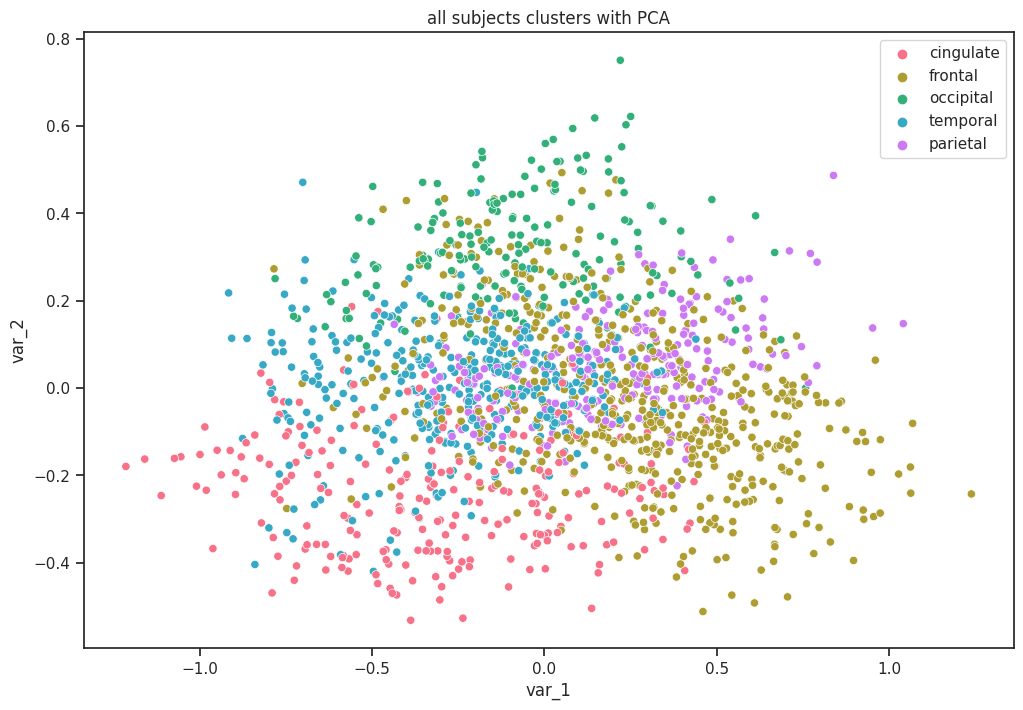

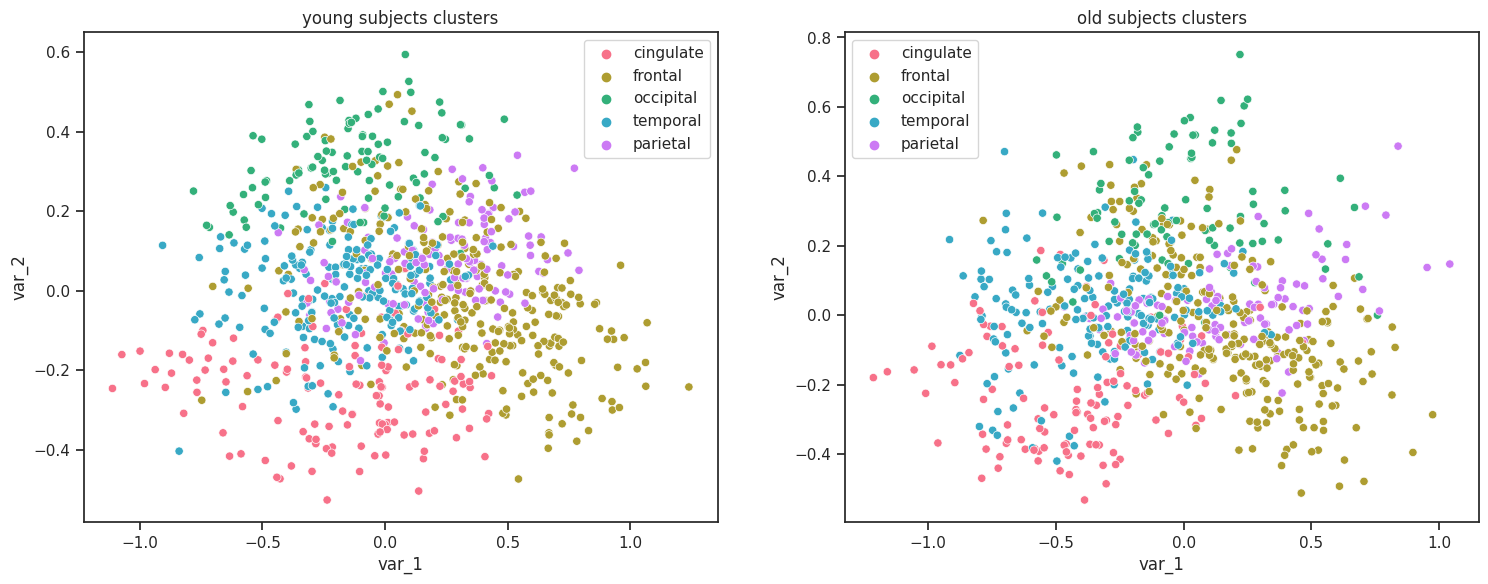

In [27]:
plt.figure(figsize=(12, 8))
plot_clusters_of_rois(all_df_reduced, chosen_data_z_score,
                      title="all subjects clusters with PCA")
plt.figure(figsize=(18, 14))
plt.subplot(2, 2, 1)
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'young'],
                      young_subjects_z_score, title="young subjects clusters")
plt.subplot(2, 2, 2)
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'old'],
                      old_subjects_z_score, title="old subjects clusters")